(dl/04-sequence-models/04cc-embeddings)=
# Character embeddings

Recall that the *n*-gram language model, that derives the next token probability distribution based on *n*-gram counts in the training data, has an inherent limitation in the context size of *n* - 1 and with *n*-grams becoming sparse as *n* increases. 

In this section, we implement a language model that learns **vector embeddings** for each character (see {cite}`Bengio2003`). This approach allows having contexts of arbitrarily length (e.g., concatenating the embeddings). Furthermore, generalization is obtained because a sequence of characters that has never been seen before gets an informative probability distribution if it is made of characters that are similar (in the sense of having a nearby representation) to those that formed a context in the training set. 

The network architecture is shown in the following figure:


```{figure} ../../../img/mlp-char-level.drawio.svg
---
width: 600px
align: center
name: mlp-char-level.drawio
---

Neural network language model with embedding layer and block size of 3. An input string `"ner"` is passed to the embedding layer. Note that the embeddings are concatenated in the correct order. The resulting concatenation of embeddings are passed to the two-layer MLP with logits.
```

The first component of the network is an **embedding matrix**, where each row corresponds to an embedding vector. Then, the embedding vectors are concatenated in the correct order and passed to the two-layer MLP to get the logits after a dense operation.

In [1]:
from chapter import *

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class MLP(nn.Module):
    def __init__(self, 
                 emb_size: int, 
                 width: int, 
                 block_size: int, 
                 vocab_size: int):
        
        super().__init__()
        self.C = nn.Embedding(vocab_size, emb_size)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(block_size * emb_size, width)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(width, vocab_size)

    def forward(self, x):
        x = self.flatten(self.C(x))
        h = self.relu(self.fc1(x))
        z = self.fc2(h)
        return z


model = MLP(emb_size=10, width=64, block_size=3, vocab_size=29)
summary(model, input_data=torch.tensor([[0, 0, 0] for _ in range(32)]))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 29]                  --
├─Embedding: 1-1                         [32, 3, 10]               290
├─Flatten: 1-2                           [32, 30]                  --
├─Linear: 1-3                            [32, 64]                  1,984
├─ReLU: 1-4                              [32, 64]                  --
├─Linear: 1-5                            [32, 29]                  1,885
Total params: 4,159
Trainable params: 4,159
Non-trainable params: 0
Total mult-adds (M): 0.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.02
Estimated Total Size (MB): 0.05

**Remark.** It is recommended that weight decay, such as L2, is applied only to the weights and not on biases, embeddings, etc., so that network expressivity is not degraded. See [this post](https://discuss.pytorch.org/t/weight-decay-only-for-weights-of-nn-linear-and-nn-conv/114348) on how to implement this.

<br>

**Backpropagation.** Calculating the gradients of the embedding matrix:

In [3]:
BLOCK_SIZE = 3
VOCAB_SIZE = 28
BATCH_SIZE = 4
x = torch.randint(low=0, high=VOCAB_SIZE, size=(BATCH_SIZE, BLOCK_SIZE))
y = torch.randint(low=0, high=VOCAB_SIZE, size=(BATCH_SIZE,))

C = torch.randn(VOCAB_SIZE, 10,     requires_grad=True)
W = torch.randn(BLOCK_SIZE * 10, 4, requires_grad=True)
b = torch.randn(4,                  requires_grad=True)

x̄     = C[x]       
x̄_cat = x̄.view(x̄.shape[0], -1)
y     = x̄_cat @ W + b

Observe that the gradient of $\bar{\boldsymbol{{\mathsf{x}}}}$ is just the gradient of $\bar{\boldsymbol{{\mathsf{x}}}}_{\text{cat}}$ reshaped. The embedding operation can be written as $\bar{\boldsymbol{{\mathsf{x}}}}_{btj} = \mathsf{C}_{\boldsymbol{\mathsf{x}}_{bt}j}.$ Hence: 

$$
\begin{aligned}
\frac{\partial\mathcal{L}}{\partial\mathsf{C}_{ij}} 
&= \sum_b \sum_t \sum_k \frac{\partial\mathcal{L}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btk}} \frac{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btk}}{\partial\mathsf{C}_{ij}} \\
&= \sum_b \sum_t \sum_k \frac{\partial\mathcal{L}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btk}} \boldsymbol{\delta}_{\boldsymbol{\mathsf{x}}_{bt}i} \boldsymbol{\delta}_{jk} \\
&= \sum_b \sum_t \boldsymbol{\delta}_{i\boldsymbol{\mathsf{x}}_{bt}}\frac{\partial\mathcal{L}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{btj}}.
\end{aligned}
$$

The last formula is simply an instruction on where to add the gradients of $\bar{\boldsymbol{{\mathsf{x}}}}$ for entries that are pulled out of $\mathsf{C}.$ However, note that we also sum over the batch index since these instances share the same embedding weights[^1].

[^1]: The formula exhibits no explicit causal structure based on the token order $t.$ But happens implicitly with the way the dataset and the network are structured, i.e. token order is preserved in each context window.

In [4]:
for u in [x̄, x̄_cat, y]:
    u.retain_grad()

loss = (y ** 2).sum(dim=1).mean()
loss.backward()

It follows that the gradient of the embedding matrix is:

In [5]:
δ = F.one_hot(x, num_classes=VOCAB_SIZE).view(-1, VOCAB_SIZE).float()
dC = δ.T @ x̄.grad.view(-1, 10)  # δ.T so (bt, i) -> (i, bt)

# Checking with autograd
print("maxdiff:", (dC - C.grad).abs().max().item(), "\texact:", torch.all(dC == C.grad).item())

maxdiff: 0.0 	exact: True


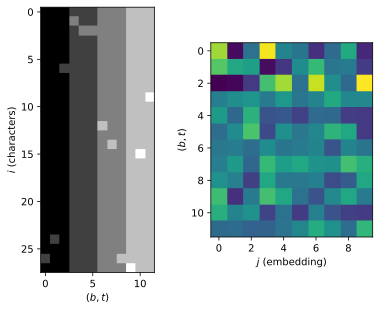

In [6]:
# Three input sequences in a batch (B = 4)
δ = F.one_hot(x, num_classes=VOCAB_SIZE).view(-1, VOCAB_SIZE).float().T
δ[:, 3: 6] += 1 # add shade
δ[:, 6: 9] += 2
δ[:, 9:12] += 3

fig, ax = plt.subplots(1, 2)
ax[0].imshow(δ.tolist(), interpolation="nearest", cmap="gray")
ax[0].set_xlabel("$(b, t)$")
ax[0].set_ylabel("$i$ (characters)")

ax[1].imshow(x̄.grad.view(-1, 10), interpolation="nearest")
ax[1].set_ylabel("$(b, t)$")
ax[1].set_xlabel("$j$ (embedding)");

**Figure.** Visualizing [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) tensor (**left**) and gradient tensor (**right**) from the above equation. The tensor $\boldsymbol{\delta}_{i\boldsymbol{\mathsf{x}}_{bt}}$ indicates all indices $(b, t)$ where the *i*-th character occurs.
All embedding vector gradients $\frac{\partial{\mathcal{L}}}{\partial\bar{\boldsymbol{{\mathsf{x}}}}_{bt:}}$ for the $i$th character are collapsed over all time steps to get 
$\frac{\partial{\mathcal{L}}}{\partial \mathsf{C}_{i:}}.$

<br>

## Model training

Reusing our [trainer engine](dl/03-cnn/03bb-trainer) code:

In [7]:
%%save
import numpy as np
from tqdm.notebook import tqdm
from contextlib import contextmanager
from torch.utils.data import DataLoader

DEVICE = "mps"


@contextmanager
def eval_context(model):
    """Temporarily set to eval mode inside context."""
    is_train = model.training
    model.eval()
    try:
        yield
    finally:
        model.train(is_train)


class Trainer:
    def __init__(self,
        model, optim, loss_fn, scheduler=None, callbacks=[],
        device=DEVICE, verbose=True
    ):
        self.model = model.to(device)
        self.optim = optim
        self.device = device
        self.loss_fn = loss_fn
        self.train_log = {"loss": [], "loss_avg": []}
        self.valid_log = {"loss": []}
        self.verbose = verbose
        self.scheduler = scheduler
        self.callbacks = callbacks
    
    def __call__(self, x):
        return self.model(x.to(self.device))

    def forward(self, batch):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        return self.model(x), y

    def train_step(self, batch):
        preds, y = self.forward(batch)
        loss = self.loss_fn(preds, y)
        loss.backward()
        self.optim.step()
        self.optim.zero_grad()
        return {"loss": loss}

    @torch.inference_mode()
    def valid_step(self, batch):
        preds, y = self.forward(batch)
        loss = self.loss_fn(preds, y, reduction="sum")
        return {"loss": loss}
    
    def run(self, epochs, train_loader, valid_loader):
        for e in tqdm(range(epochs)):
            for batch in train_loader:
                # optim and lr step
                output = self.train_step(batch)
                if self.scheduler:
                    self.scheduler.step()

                # step callbacks
                for callback in self.callbacks:
                    callback()

                # logs @ train step
                steps_per_epoch = len(train_loader)
                w = int(0.05 * steps_per_epoch)
                self.train_log["loss"].append(output["loss"].item())
                self.train_log["loss_avg"].append(np.mean(self.train_log["loss"][-w:]))

            # logs @ epoch
            output = self.evaluate(valid_loader)
            self.valid_log["loss"].append(output["loss"])
            if self.verbose:
                print(f"[Epoch: {e+1:>0{int(len(str(epochs)))}d}/{epochs}]    loss: {self.train_log['loss_avg'][-1]:.4f}    val_loss: {self.valid_log['loss'][-1]:.4f}")

    def evaluate(self, data_loader):
        with eval_context(self.model):
            valid_loss = 0.0
            for batch in data_loader:
                output = self.valid_step(batch)
                valid_loss += output["loss"].item()

        return {"loss": valid_loss / len(data_loader.dataset)}

    @torch.inference_mode()
    def predict(self, x: torch.Tensor):
        with eval_context(self.model):
            return self(x)

import numpy as np
from tqdm.notebook import tqdm
from contextlib import contextmanager
from torch.utils.data import DataLoader

DEVICE = "mps"


@contextmanager
def eval_context(model):
    """Temporarily set to eval mode inside context."""
    is_train = model.training
    model.eval()
    try:
        yield
    finally:
        model.train(is_train)


class Trainer:
    def __init__(self,
        model, optim, loss_fn, scheduler=None, callbacks=[],
        device=DEVICE, verbose=True
    ):
        self.model = model.to(device)
        self.optim = optim
        self.device = device
        self.loss_fn = loss_fn
        self.train_log = {"loss": [], "loss_avg": []}
        self.valid_log = {"loss": []}
        self.verbose = verbose
        self.scheduler = scheduler
        self.callbacks = callbacks
    
    def __call__(self, x):
        return self.model(x.to(self.device))

    def forward(self, batch):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        return self.model(x), y

    def train_step(self, batch):
        preds, y = self.forward(batch)
        loss = self.loss_fn(preds, y)
        loss.backward()
        self.optim.step()
        self.optim.zero_grad()
        return {"loss": loss}

    @torch.inference_mode()
    def valid_step(self, batch):
        preds, y = self.forward(batch)
        loss = self.loss_fn(preds, y, reduction="sum")
        return {"loss": loss}
    
    def run(self, epochs, train_loader, valid_loader):
        for e in tqdm(range(epochs)):
            for batch in train_loader:
                # optim and lr step
                output = self.train_step(batch)
                if self.scheduler:
                    self.scheduler.step()

                # step callbacks
                for callback in self.callbacks:
                    callback()

                # logs @ train step
                steps_per_epoch = len(train_loader)
                w = int(0.05 * steps_per_epoch)
                self.train_log["loss"].append(output["loss"].item())
                self.train_log["loss_avg"].append(np.mean(self.train_log["loss"][-w:]))

            # logs @ epoch
            output = self.evaluate(valid_loader)
            self.valid_log["loss"].append(output["loss"])
            if self.verbose:
                print(f"[Epoch: {e+1:>0{int(len(str(epochs)))}d}/{epochs}]    loss: {self.train_log['loss_avg'][-1]:.4f}    val_loss: {self.valid_log['loss'][-1]:.4f}")

    def evaluate(self, data_loader):
        with eval_context(self.model):
            valid_loss = 0.0
            for batch in data_loader:
                output = self.valid_step(batch)
                valid_loss += output["loss"].item()

        return {"loss": valid_loss / len(data_loader.dataset)}

    @torch.inference_mode()
    def predict(self, x: torch.Tensor):
        with eval_context(self.model):
            return self(x)

In [8]:
from torch.optim.lr_scheduler import OneCycleLR

DEVICE = "mps"
PAD_TOKEN = "."
BATCH_SIZE = 128
names = load_surnames()
vocab = Vocab(text="".join(names), preprocess=False, reserved_tokens=[PAD_TOKEN])
split_point = int(0.80 * len(names))

train_dataset = CharDataset(names[:split_point], block_size=BLOCK_SIZE, vocab=vocab)
valid_dataset = CharDataset(names[split_point:], block_size=BLOCK_SIZE, vocab=vocab)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

epochs = 15
model = MLP(emb_size=3, width=64, block_size=BLOCK_SIZE, vocab_size=len(vocab)).to(DEVICE)
loss_fn = F.cross_entropy
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epochs)
trainer = Trainer(model, optim, loss_fn, scheduler, device=DEVICE)
trainer.run(epochs=epochs, train_loader=train_loader, valid_loader=valid_loader)

  0%|          | 0/15 [00:00<?, ?it/s]

[Epoch: 01/15]    loss: 2.5792    val_loss: 2.6122
[Epoch: 02/15]    loss: 2.4416    val_loss: 2.4541
[Epoch: 03/15]    loss: 2.4171    val_loss: 2.4154
[Epoch: 04/15]    loss: 2.3955    val_loss: 2.4167
[Epoch: 05/15]    loss: 2.3968    val_loss: 2.3993
[Epoch: 06/15]    loss: 2.3968    val_loss: 2.3793
[Epoch: 07/15]    loss: 2.3484    val_loss: 2.3722
[Epoch: 08/15]    loss: 2.3653    val_loss: 2.3659
[Epoch: 09/15]    loss: 2.3582    val_loss: 2.3570
[Epoch: 10/15]    loss: 2.3296    val_loss: 2.3471
[Epoch: 11/15]    loss: 2.3508    val_loss: 2.3401
[Epoch: 12/15]    loss: 2.3184    val_loss: 2.3328
[Epoch: 13/15]    loss: 2.3061    val_loss: 2.3276
[Epoch: 14/15]    loss: 2.3257    val_loss: 2.3257
[Epoch: 15/15]    loss: 2.3172    val_loss: 2.3254


This performs better than the 4-gram count model.

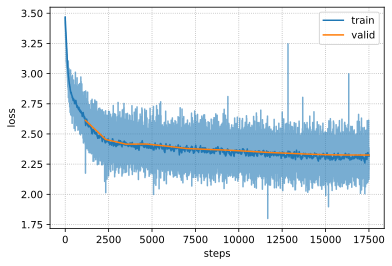

In [9]:
from matplotlib.ticker import StrMethodFormatter

num_epochs = len(trainer.valid_log["loss"])
num_steps_per_epoch = len(trainer.train_log["loss"]) // num_epochs

plt.figure(figsize=(6, 4))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}")) # 2 decimal places
plt.plot(trainer.train_log["loss"], alpha=0.6, color="C0")
plt.plot(trainer.train_log["loss_avg"], color="C0", label="train")
plt.plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log["loss"], label="valid", color="C1")
plt.ylabel("loss")
plt.xlabel("steps")
plt.grid(linestyle="dotted")
plt.legend();

Generated names are starting to look natural:

In [10]:
for _ in range(10):
    n = generate_name(lambda x: F.softmax(model.to("cpu")(x), dim=1), train_dataset, seed=_)
    print(n)

pamenza
mopin_sag
berhecuriiti
bajes
de_koz_degui
moz_de_arbinentio
gor
goyacipuesteral
lamran
binatza


Looking at the trained character embeddings:

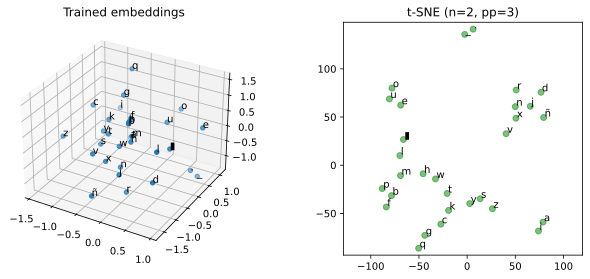

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0], projection="3d")
ax2 = fig.add_subplot(gs[1])
chars = list(train_dataset.vocab.tokens)

# Scatter plot the embeddings; annotate
embeddings = model.C.weight.data.detach().cpu().numpy()
ax1.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2])
ax1.set_title("Trained embeddings")
for i, c in enumerate(chars):
    c = "?" if c == "<unk>" else c
    ax1.text(embeddings[i, 0], embeddings[i, 1], embeddings[i, 2], c)

# Apply t-SNE
PP = 3
tsne = TSNE(n_components=2, perplexity=PP, random_state=42)
tsne_emb = tsne.fit_transform(model.C.weight.data)

ax2.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c="green", alpha=0.5)
ax2.axis("equal")
ax2.set_title(f"t-SNE (n=2, pp={PP})")
for i, c in enumerate(chars):
    c = "?" if c == "<unk>" else c
    ax2.text(tsne_emb[i, 0] + 1.0, tsne_emb[i, 1] + 1.0, c)

fig.tight_layout()

**Figure.** Vowels are isolated, as well as `_` and `.`. Interestingly, the unknown token ▮ is located near other letters. In general, tight clustering of characters in t-SNE may indicate that these characters are not fully understood by the network[^2].

[^2]: A tight clustering of embedding vectors hints that embedding dimension may be a bottleneck, and therefore can be increased to improve performance. Indeed, performance improved after increasing embedding dimension from 2 (not shown) to 3 with the rest of the variables fixed.